In [1]:
import logging
from nltk import word_tokenize
import pandas as pd
import numpy as np
import gc
import os
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
from torch import optim
import torchtext
import random
import matplotlib.pyplot as plt
import copy, time

import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
text = torchtext.data.Field(lower=True, batch_first=True, tokenize=word_tokenize)
qid = torchtext.data.Field()

C:\Users\Nikita\AppData\Local\Continuum\anaconda3\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [3]:
start = time.time()
target = torchtext.data.Field(sequential=False, use_vocab=False, is_target=True)
train = torchtext.data.TabularDataset(path='./data/train1.csv', format='csv',
                                      
                                     fields={'question_text': ('text',text),
                                              'target': ('target',target)})
test = torchtext.data.TabularDataset(path='./data/test.csv', format='csv',
                                     fields={'qid': ('qid', qid),
                                             'question_text': ('text', text)})
end = time.time()
print((end - start)/ 60)

C:\Users\Nikita\AppData\Local\Continuum\anaconda3\lib\site-packages\torchtext\data\example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
C:\Users\Nikita\AppData\Local\Continuum\anaconda3\lib\site-packages\torchtext\data\example.py:52: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


0.922158169746399


In [4]:
text.build_vocab(train, test, min_freq=3)
qid.build_vocab(test)
text.vocab.load_vectors(torchtext.vocab.Vectors(r"C:\Users\Nikita\PycharmProjects\Sem_2\data\Quora\embeddings\wiki-news-300d-1M.vec"))

In [5]:
print(text.vocab.vectors.shape)

torch.Size([38053, 300])


In [6]:
random.seed(2020)
train, val = train.split(split_ratio=0.9, random_state=random.getstate())

In [7]:
class BiLSTM(nn.Module):
    def __init__(self, pretrained_lm, padding_idx, static=True, hidden_dim=128, lstm_layer=2, dropout=0.2):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(p=dropout)
        self.embedding = nn.Embedding.from_pretrained(pretrained_lm)
        self.embedding.padding_idx = padding_idx
        if static:
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(input_size=self.embedding.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=lstm_layer,
                            dropout=dropout,
                            bidirectional=True)
        self.hidden2label = nn.Linear(hidden_dim * lstm_layer * 2, 1)

    def forward(self, sents):
        x = self.embedding(sents)
        x = torch.transpose(x, dim0=1, dim1=0)
        lstm_out, (h_n, c_n) = self.lstm(x)
        y = self.hidden2label(self.dropout(torch.cat([c_n[i, :, :] for i in range(c_n.shape[0])], dim=1)))
        return y

In [8]:
def training(num_epochs, model, loss_func, optimizer, train_iter, val_iter):
    
    step = 0
    train_record = []
    val_record = []
     
    for epoch in range(num_epochs):
        tr_loss = []
        for train_batch in iter(train_iter):
            step += 1
            model.train()
            x = train_batch.text
            y = train_batch.target.type(torch.Tensor)
            model.zero_grad()
            pred = model.forward(x)
            loss = loss_function(pred.view(-1), y)
            tr_loss.append(loss.cpu().data.numpy())
            loss.backward()
            optimizer.step()
            
            if step % 250 == 0 :
                model.eval()
                model.zero_grad()
                val_loss = []
                for val_batch in iter(val_iter):
                    
                    val_x = val_batch.text
                    val_y = val_batch.target.type(torch.Tensor)
                    val_pred = model.forward(val_x).view(-1)
                    val_loss.append(loss_function(val_pred, val_y).cpu().data.numpy())
                    
                val_record.append({'step': step, 'loss': np.mean(val_loss)})
                train_record.append({'step': step, 'loss':  np.mean(tr_loss)})

                print('epoch {:02} - step {:06} - train_loss {:.4f} - val_loss {:.4f} '.format(
                    epoch, step,  train_record[-1]['loss'], val_record[-1]['loss']))
                
    save(m=model, info={'step': step, 'num_epochs': num_epochs, 'train_loss': train_record[-1]['loss'],
        'val_loss': val_record[-1]['loss'], 'tr_record':train_record,  'val_record':val_record})    
    
    return train_record, val_record


In [9]:
def save(m, info):
    torch.save(info, 'model.info')
    torch.save(m, 'model.m')
def load():
    m = torch.load('model.m')
    info = torch.load('model.info')
    return m, info    

In [10]:
batch_size = 256

In [11]:
train_iter = torchtext.data.BucketIterator(dataset=train,
                                               batch_size=batch_size,
                                               sort_key=lambda x: x.text.__len__(),
                                               shuffle=True,
                                               sort=False)
val_iter = torchtext.data.BucketIterator(dataset=val,
                                             batch_size=batch_size,
                                             sort_key=lambda x: x.text.__len__(),
                                             train=False,
                                             sort=False)

C:\Users\Nikita\AppData\Local\Continuum\anaconda3\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [12]:
step = 0
for train_batch in iter(train_iter):
    step += 1
for val_batch in iter(val_iter):
    step += 1
print(step)

C:\Users\Nikita\AppData\Local\Continuum\anaconda3\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


1368


In [13]:
model = BiLSTM(text.vocab.vectors, lstm_layer=2, padding_idx=text.vocab.stoi[text.pad_token], hidden_dim=128)

In [14]:
loss_function = nn.BCEWithLogitsLoss()

In [15]:
num_epochs = 5

In [16]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                    lr=0.001)

In [17]:
start = time.time()

t_record, v_record = training(model=model, num_epochs=num_epochs, 
         loss_func=loss_function, optimizer=optimizer, train_iter=train_iter,
        val_iter=val_iter)

end = time.time()
print((end - start)/ 60)

epoch 00 - step 000250 - train_loss 0.1631 - val_loss 0.1319 
epoch 00 - step 000500 - train_loss 0.1478 - val_loss 0.1291 
epoch 00 - step 000750 - train_loss 0.1409 - val_loss 0.1254 
epoch 00 - step 001000 - train_loss 0.1357 - val_loss 0.1217 
epoch 01 - step 001250 - train_loss 0.1268 - val_loss 0.1229 
epoch 01 - step 001500 - train_loss 0.1214 - val_loss 0.1203 
epoch 01 - step 001750 - train_loss 0.1200 - val_loss 0.1181 
epoch 01 - step 002000 - train_loss 0.1190 - val_loss 0.1160 
epoch 01 - step 002250 - train_loss 0.1181 - val_loss 0.1219 
epoch 02 - step 002500 - train_loss 0.1042 - val_loss 0.1176 
epoch 02 - step 002750 - train_loss 0.1110 - val_loss 0.1146 
epoch 02 - step 003000 - train_loss 0.1107 - val_loss 0.1141 
epoch 02 - step 003250 - train_loss 0.1106 - val_loss 0.1125 
epoch 02 - step 003500 - train_loss 0.1112 - val_loss 0.1175 
epoch 03 - step 003750 - train_loss 0.1106 - val_loss 0.1135 
epoch 03 - step 004000 - train_loss 0.1089 - val_loss 0.1120 
epoch 03

In [18]:
t = [ t_record[i]['loss']  for i in range(len(t_record))]
v = [ v_record[i]['loss']  for i in range(len(t_record))]
t

[0.16314323,
 0.14776018,
 0.14092098,
 0.13573563,
 0.12678596,
 0.12144829,
 0.11995312,
 0.11896224,
 0.1180519,
 0.104211785,
 0.11102244,
 0.11067675,
 0.11063088,
 0.11120291,
 0.11058919,
 0.108896025,
 0.10817127,
 0.107382946,
 0.10689994,
 0.103358544,
 0.101557024,
 0.102642946,
 0.10336297,
 0.10325315]

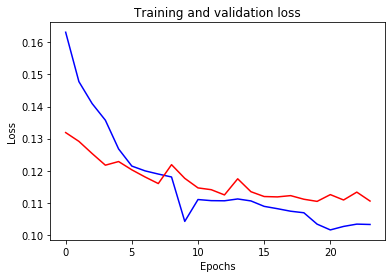

In [19]:
x = np.arange(len(v))
plt.plot(x, t, 'b', label='Training loss')
plt.plot(x, v, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [20]:
bilstm_model, bilstm_info = load()
print(bilstm_info)
bilstm_model.lstm.flatten_parameters()

{'step': 6155, 'num_epochs': 5, 'train_loss': 0.10325315, 'val_loss': 0.11055074, 'tr_record': [{'step': 250, 'loss': 0.16314323}, {'step': 500, 'loss': 0.14776018}, {'step': 750, 'loss': 0.14092098}, {'step': 1000, 'loss': 0.13573563}, {'step': 1250, 'loss': 0.12678596}, {'step': 1500, 'loss': 0.12144829}, {'step': 1750, 'loss': 0.11995312}, {'step': 2000, 'loss': 0.11896224}, {'step': 2250, 'loss': 0.1180519}, {'step': 2500, 'loss': 0.104211785}, {'step': 2750, 'loss': 0.11102244}, {'step': 3000, 'loss': 0.11067675}, {'step': 3250, 'loss': 0.11063088}, {'step': 3500, 'loss': 0.11120291}, {'step': 3750, 'loss': 0.11058919}, {'step': 4000, 'loss': 0.108896025}, {'step': 4250, 'loss': 0.10817127}, {'step': 4500, 'loss': 0.107382946}, {'step': 4750, 'loss': 0.10689994}, {'step': 5000, 'loss': 0.103358544}, {'step': 5250, 'loss': 0.101557024}, {'step': 5500, 'loss': 0.102642946}, {'step': 5750, 'loss': 0.10336297}, {'step': 6000, 'loss': 0.10325315}], 'val_record': [{'step': 250, 'loss': 

In [21]:
bilstm_model.eval()
val_pred = []
val_true = []
val_iter.init_epoch()
for val_batch in iter(val_iter):
    val_x = val_batch.text
    val_true += val_batch.target.data.numpy().tolist()
    val_pred += torch.sigmoid(bilstm_model.forward(val_x).view(-1)).cpu().data.numpy().tolist()


In [22]:
tmp = [0,0,0] 
delta = 0
for tmp[0] in np.arange(0.1, 0.501, 0.01):
    tmp[1] = f1_score(val_true, np.array(val_pred)>tmp[0])
    if tmp[1] > tmp[2]:
        delta = tmp[0]
        tmp[2] = tmp[1]
print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))


best threshold is 0.2300 with F1 score: 0.6468
